In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
try:
    import filterpy
except ImportError:
    !pip install filterpy
from filterpy.kalman import KalmanFilter, EnsembleKalmanFilter, UnscentedKalmanFilter, MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise, Saver
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

     |################################| 184kB 6.7MB/s eta 0:00:01
  Created wheel for filterpy: filename=filterpy-1.4.5-cp36-none-any.whl size=110452 sha256=12e71ba255a9fef99074374ebbf4ba8d538b90475e921fc36289ab072b4877a0
  Stored in directory: /home/wsuser/.cache/pip/wheels/c3/0c/dd/e92392c3f38a41371602d99fc77d6c1d42aadbf0c6afccdd02
Successfully built filterpy


In [2]:
!pip install ipywidgets

In [3]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

### Kalman filters

In [4]:
def kalman_predictor(initial_state, kf_p, kf_r, kf_q, kf_a):
    """
    We model Covid development as a dynamical system composed of 3 components:
    - measurement (observable) = case count,
    - speed (latent) = growth rate (cases per day)
    - acceleration (latent) = growth acceleration (cases per day^2)    
    - used params of kf_p=0, kf_r=10, kf_q=20
    """
    # day is our observation interval
    dt = 1
    # transition matrix (x:measurement, v:growth rate, a:growth acceleration)
    F = np.array([[1, dt, 0.5*(dt**2)], # x_new           = x_old + v*dt + 1/2*a*dt^2
                    [0, 1, dt],           # d(v_new) / dt   = v     + a*dt + 0
                    [0, 0, 1]])           # d(x_new) / dt^2 = 0     + 0    + a
    '''
    F = np.array([[1, dt, (dt**2)/2, (dt**3)/6], # x_new = x_old + v*dt + 1/2*a*dt^2 + 1/6*j*dt^3
                  [0, 1, dt, (dt**2)/2],         # d(x_new) / dt = v + a*dt + 1/2*j*dt^2
                  [0, 0, 1, dt],                 # d(v_new) / dt = a + jt
                  [0, 0, 0, 1]])                 # d(a_new) / dt = j
    '''
    # define a linear KF with position, velocity, acceleration parameters
    dim_x = F.shape[0]
    kf = KalmanFilter(dim_x=dim_x, dim_z=1)
    kf.F = F
    # state vector: initial position, velocity, acceleration
    kf.x = np.zeros(dim_x)
    kf.x[0] = initial_state
    # measuremnet matrix: can only directly measure case counts, not velocity & acceleration
    kf.H = np.zeros((1, dim_x))
    kf.H[0][0] = 1
    # covariance matrix
    kf.P *= kf_p
    # measurement noise
    kf.R = kf_r
    # process noise
    kf.Q = Q_discrete_white_noise(dim=dim_x, dt=1, var=kf_q)
    # fading factor
    kf.alpha = kf_a
    return kf

def ensemble_kalman_predictor(initial_state, kf_p, kf_r, kf_q, kf_n):
    """
    We model Covid development as a dynamical system composed of 3 components:
    - measurement (observable) = case count,
    - speed (latent) = growth rate (cases per day)
    - acceleration (latent) = growth acceleration (cases per day^2)
    """
    # day is our observation interval
    dt = 1
    # transition matrix (x:measurement, v:growth rate, a:growth acceleration)
    F = np.array([[1, dt, (dt**2)/2], # x_new           = x_old + v*dt + 1/2*a*dt^2
                  [0, 1, dt],           # d(x_new) / dt   = v     + a*dt + 0
                  [0, 0, 1]])           # d(x_new) / dt^2 = 0     + 0    + a
    ''' also consider jerk
    F = np.array([[1, dt, (dt**2)/2, (dt**3)/6], # x_new = x_old + v*dt + 1/2*a*dt^2 + 1/6*j*dt^3
                  [0, 1, dt, (dt**2)/2],         # d(x_new) / dt = v + a*dt + 1/2*j*dt^2
                  [0, 0, 1, dt],                 # d(v_new) / dt = a + jt
                  [0, 0, 0, 1]])                 # d(a_new) / dt = j
    '''
    # state vector: initial position, velocity, acceleration
    X0 = np.zeros(F.shape[0])
    X0[0] = initial_state
    # transition function
    Fx = lambda x, dt: np.dot(F, x)
    # measuremnet function
    Hx = lambda x: np.array([x[0]])
    # covariance matrix
    P = np.eye(F.shape[0]) * kf_p
    # measurement noise
    R = kf_r
    # process noise
    Q = Q_discrete_white_noise(dim=F.shape[0], dt=1, var=kf_q)
    # let's make it
    kf = EnsembleKalmanFilter(x=X0, P=P, dim_z=1, dt=1, N=kf_n, hx=Hx, fx=Fx)
    kf.R = R
    kf.Q = Q
    return kf

### Forecast

In [5]:
def kalman_forecast(series, days, kf_type, params):
    """
    Forecast based on history data.
    
    Input
    -----
    series: Pandas Series object with dates being index in ascending order.
    days: Prediction window length
    kf_type: linear, unscented, ensemble
    kf_*: Parameters for Kalman filter. Default values work reasonably well on several countries.
    
    Output
    ------
    Pandas DataFrame object with the following columns
    pred_raw: Raw prediction
    pred: Final prediction (with smoothing, etc.)
    ci_*: Lower and upper bounds of CI
    """
    if days <= 0:
        raise ValueError
    dates = series.index
    if kf_type == 'linear':
        if params is None:
            params = {'kf_p':1, 'kf_r':4, 'kf_q':0.1, 'kf_a':1}
        if params['kf_a'] < 1:
            raise ValueError
        kf = kalman_predictor(series[dates[0]], params['kf_p'], params['kf_r'], params['kf_q'], params['kf_a'])
    elif kf_type == 'ensemble':
        if params is None:
            params = {'kf_p':100, 'kf_r':1000, 'kf_q':0.1, 'kf_n':1000}
        kf = ensemble_kalman_predictor(series[dates[0]], params['kf_p'], params['kf_r'], params['kf_q'], params['kf_n'])
    else:
        raise NotImplementedError
    
    # fit model
    for measurement in series:
        kf.predict()
        kf.update([measurement])
    
    # start forecasting, starting from the last observation date
    last_date = dt.datetime.strptime(dates[-1], '%m-%d')
    predictions = [series[-1]]
    pred_dates = [dates[-1]]
    ci_bounds = [0]
    for day in range(days):
        future_date = (last_date + dt.timedelta(days=day+1)).strftime('%m-%d')
        pred_dates.append(future_date)
        kf.predict()
        predictions.append(kf.x[0])
        ci_bounds.append(kf_ci_bound(kf))
    
    # smoothen and add confidence intervals
    predictions = np.array(predictions)
    predictions[np.where(predictions < 0)[0]] = 0
    #smooth_buffer = list(series[dates[len(dates)-days+1:]])
    #predictions_smooth = smoother(smooth_buffer + predictions, days)[days-1:]
    predictions_smooth = smoother(predictions, days)
    ci_bounds = np.array(ci_bounds)
    ci_upper = predictions_smooth + ci_bounds
    ci_lower = predictions_smooth - ci_bounds
    ci_lower[np.where(ci_lower < 0)[0]] = 0
    
    df_pred = pd.DataFrame({'pred_raw':predictions, 'pred':predictions_smooth,
                          'ci_lower':ci_lower, 'ci_upper':ci_upper}, index=pred_dates)
    return df_pred

def kf_ci_bound(kf):
    """
    Compute 95% confidence interval from KF's positive semi-definite covariance matrix
    
    returns a positive single-sided boundary (half) of the interval
    -> CI = kf.x[0] +- kf_ci_bound(kf)
    """
    return 1.96 * (np.diag(kf.P)[0])**0.5

def smoother(x, winsize, method='slide'):
    if method == 'slide':
        x_smooth = []
        for i in range(len(x)):
            x_smooth.append(np.mean(x[max(0, i-winsize+1):i+1]))
    elif method == 'slide_recurse':
        x_smooth = predictions.copy()
        for i in range(len(x)):
            x_smooth[i] = np.mean(x_smooth[max(0, i-winsize):i+1])
    else:
        raise NotImplementedError
    assert(len(x) == len(x_smooth))
    return np.array(x_smooth)

def get_stats(observations, predictions):
    r2 = r2_score(observations, predictions)
    mae = mean_absolute_error(observations, predictions)
    rmse = mean_squared_error(observations, predictions) ** 0.5
    return r2, mae, rmse

def rescale(df_x):
    x = df_x.copy()
    x -= x.min()
    x /= x.max()
    return x

### Performance validation

In [6]:
def kalman_test(series, winsize, kf_type, params=None):
    """
    To test the performance compared with true values along all data points
    
    Input
    -----
    series: Pandas Series object with dates being index in ascending order.
    winsize: Prediction window size in number of days.
    kf_type: linear, unscented, ensemble
    kf_*: factors for Kalman filter. Default values work reasonably well.
          For long-term prediction, usually increasing the fading factor (kf_a) helps.
    
    Output
    ------
    Pandas DataFrame object with the following columns
    pred_raw: Raw prediction
    pred: Final prediction (with smoothing, etc.)
    obs: Ground-truth values
    history: recursive prediction history at each time point (for debugging purpose)
    """
    if winsize <= 0:
        raise ValueError
    observations = []
    predictions = []
    pred_dates = []
    history = []
    ci_bounds = []
    dates = series.index.to_numpy()
    if kf_type == 'linear':
        if params is None:
            params = {'kf_p':1, 'kf_r':4, 'kf_q':0.1, 'kf_a':1}
        if params['kf_a'] < 1:
            raise ValueError
        kf = kalman_predictor(series[dates[0]], params['kf_p'], params['kf_r'], params['kf_q'], params['kf_a'])
    elif kf_type == 'ensemble':
        if params is None:
            params = {'kf_p':100, 'kf_r':1000, 'kf_q':0.1, 'kf_n':1000}
        kf = ensemble_kalman_predictor(series[dates[0]], params['kf_p'], params['kf_r'], params['kf_q'], params['kf_n'])
    else:
        raise NotImplementedError(kf_type)
    
    for i in range(dates.shape[0]-winsize):
        # save the current state of the model
        saver = Saver(kf, skip_callable=True, save_current=True)
        
        # recursive prediction
        history_window = [kf.x[0]]
        date_window = [dates[i]]
        for day in range(winsize):
            kf.predict()
            history_window.append(kf.x[0])
            date_window.append(dates[i+day+1])
        history.append(pd.DataFrame({'pred':history_window}, index=date_window))
        pred_date = dates[i+winsize]
        pred_dates.append(pred_date)
        prediction = kf.x[0]
        predictions.append(prediction)
        observation = series[pred_date]
        observations.append(observation)
        ci_bounds.append(kf_ci_bound(kf))
        
        # restore model states and update to next day
        for attr in saver.keys:
            try:
                setattr(kf, attr, getattr(saver, attr)[-1])
            except AttributeError: # property decoration causes problem
                #print('.%s skip' % attr)
                continue
        kf.predict()
        kf.update([series[dates[i+1]]])
    
    # smoothen output
    predictions_smooth = smoother(predictions, winsize)
    predictions_smooth[predictions_smooth < 0] = 0
    ci_bounds = np.array(ci_bounds)
    ci_lower = predictions_smooth - ci_bounds
    ci_upper = predictions_smooth + ci_bounds
    ci_lower[np.where(ci_lower < 0)[0]] = 0
    df_pred = pd.DataFrame({'pred_raw':predictions[winsize:], 'pred':predictions_smooth[winsize:],
                          'obs':observations[winsize:], 'history':history[winsize:],
                          'ci_lower':ci_lower[winsize:], 'ci_upper':ci_upper[winsize:]}, index=pred_dates[winsize:])
    return df_pred

### Predict & Plot

In [7]:
def test_plot(series, winsize, kf_type, params=None, title='', y_lims=None):
    """
    Make a prediction and plot at once for convenience.
    
    """
    PLOT_RAW = True
    SHOW_TRAJECTORY = True
    
    result = kalman_test(series, winsize, kf_type, params)
    forecast = kalman_forecast(series, winsize, kf_type, params)
    r2, mae, rmse = get_stats(result.obs, result.pred)
    #r2, mae, rmse = get_stats(result.obs, result.pred_raw)
    plt.rcParams.update({'figure.max_open_warning': 0})
    plt.figure(figsize=[13,5])
    plt.plot(series.index, series, 'o', color='g', linewidth=3)
    plt.plot(result.index, result.pred, '-', color=(1,0,0,0.8), linewidth=3)
    if PLOT_RAW:
        plt.plot(result.index, result.pred_raw, 'o', color=(1,0,0,0.3), linewidth=3)
        plt.plot(forecast.index, forecast.pred_raw, 'o', color=(1,0,0,0.3), linewidth=3)
    plt.fill_between(result.index, result.ci_lower, result.ci_upper, color=(1,0,0,0.1))
    plt.plot(forecast.index, forecast.pred, color='r', linewidth=3)
    plt.fill_between(forecast.index, forecast.ci_lower, forecast.ci_upper, color=(1,0,0,0.1))
    if SHOW_TRAJECTORY:
        for df_h in result.history:
            plt.plot(df_h.index, df_h.pred, '-', color=(0,0,1,0.2))
    if y_lims:
        plt.ylim(y_lims)
    plt.xticks(rotation=45, fontsize='small')
    plt.title(r'%s ($r^2$:%.3f, mae:%d, rmse:%d=%.1f%% of global max %d)' % (title, r2, mae, rmse, rmse * 100 / series.max(), series.max()))
    plt.legend(['True', 'Prediction'])
    plt.grid(True, 'both')
    plt.tight_layout()

In [8]:
def forecast_plot(series, winsize, kf_type, params=None, title='', y_lims=None):
    """
    Make a prediction and plot at once for convenience.    
    """
    PLOT_RAW = True
    
    forecast = kalman_forecast(series, winsize, kf_type, params)
    plt.rcParams.update({'figure.max_open_warning': 0})
    plt.figure(figsize=[13,5])
    plt.plot(series.index, series, 'o', color='g', linewidth=3)
    plt.plot(forecast.index, forecast.pred, '-', color=(1,0,0,0.9), linewidth=3)
    if PLOT_RAW:
        plt.plot(forecast.index, forecast.pred_raw, '.', color='r')
    plt.fill_between(forecast.index, forecast.ci_lower, forecast.ci_upper, color=(1,0,0,0.1))
    if y_lims:
        plt.ylim(y_lims)
    plt.xticks(rotation=45, fontsize='small')
    plt.title(title)
    plt.legend(['True', 'Prediction'])
    plt.grid(True, 'both')
    plt.tight_layout()

### Italy data - Wrangling

In [17]:

df_italy_regions = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv')
df_italy_regions.head()


,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,...,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note
0,2020-02-24T18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,...,0,0,0,0,NaN,NaN,0,5,NaN,NaN
1,2020-02-24T18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,...,0,0,0,0,NaN,NaN,0,0,NaN,NaN
2,2020-02-24T18:00:00,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,...,0,0,0,0,NaN,NaN,0,1,NaN,NaN
3,2020-02-24T18:00:00,ITA,15,Campania,40.839566,14.250850,0,0,0,0,...,0,0,0,0,NaN,NaN,0,10,NaN,NaN
4,2020-02-24T18:00:00,ITA,8,Emilia-Romagna,44.494367,11.341721,10,2,12,6,...,0,18,0,0,NaN,NaN,18,148,NaN,NaN


In [18]:
df_italy_regions.columns

Index(['data', 'stato', 'codice_regione', 'denominazione_regione', 'lat',
       'long', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'casi_da_sospetto_diagnostico', 'casi_da_screening',
       'totale_casi', 'tamponi', 'casi_testati', 'note'],
      dtype='object')

In [19]:
info_regions = df_italy_regions[['data', 'codice_regione', 'denominazione_regione', 'lat',
       'long', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'totale_casi', 'tamponi', 'casi_testati']]

# transaltion in English
info_regions.columns = ['date', 'region_code', 'region', 'lat',
       'long', 'hospitalised_w_symptoms', 'intensive_care',
       'tot_hospitalised', 'isolation', 'confirmed_cases',
       'var_confirmed_cases', 'new_confirmed_cases', 'recovered',
       'fatalities', 'tot_cases', 'tests', 'tested_cases']
info_regions.head()

,date,region_code,region,lat,long,hospitalised_w_symptoms,intensive_care,tot_hospitalised,isolation,confirmed_cases,var_confirmed_cases,new_confirmed_cases,recovered,fatalities,tot_cases,tests,tested_cases
0,2020-02-24T18:00:00,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,0,5,NaN
1,2020-02-24T18:00:00,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,0,0,NaN
2,2020-02-24T18:00:00,18,Calabria,38.905976,16.594402,0,0,0,0,0,0,0,0,0,0,1,NaN
3,2020-02-24T18:00:00,15,Campania,40.839566,14.250850,0,0,0,0,0,0,0,0,0,0,10,NaN
4,2020-02-24T18:00:00,8,Emilia-Romagna,44.494367,11.341721,10,2,12,6,18,0,18,0,0,18,148,NaN


## All the regions in Italy 

In [20]:
regions = ['Abruzzo', 'Basilicata', 'Calabria', 'Campania', 'Emilia-Romagna',
       'Friuli Venezia Giulia', 'Lazio', 'Liguria', 'Lombardia', 'Marche',
       'Molise', 'P.A. Bolzano', 'P.A. Trento', 'Piemonte', 'Puglia',
       'Sardegna', 'Sicilia', 'Toscana', 'Umbria', "Valle d'Aosta",
       'Veneto']

In [21]:
key = 'fatalities'
winsize = 6
save_png = False
kf_type = 'ensemble'
kf_params = {'kf_p':1, 'kf_r':100, 'kf_q':0.01, 'kf_n':1000}

In [22]:
def show_one_region(region, variable_of_interest): 
    key = variable_of_interest
    df_country = info_regions[info_regions.region == region].groupby('date').sum()

    df_country.index = pd.to_datetime(df_country.index, format='%Y-%m-%d').strftime('%m-%d')
    df_country = df_country[df_country.index >= '02-10'] # most measurement data starts from March
    y_lims = [min(df_country[key]) * 0.5, max(df_country[key]) * 1.5]
    test_plot(df_country[key], winsize, kf_type, kf_params, '%s: %d-day prediction of %s' % (region, winsize, key), y_lims=y_lims)
    if save_png:
        plt.savefig('%s_%s.png' % (region, key), dpi=144, transparent=False)
        plt.close()
    return 

In [23]:
@interact
def show_options(variable=['fatalities', 'confirmed_cases'], 
                            region=regions):
    return show_one_region(region, variable)

interactive(children=(Dropdown(description='variable', options=('fatalities', 'confirmed_cases'), value='fatal…

## All Regions in Italy (Fatalities)

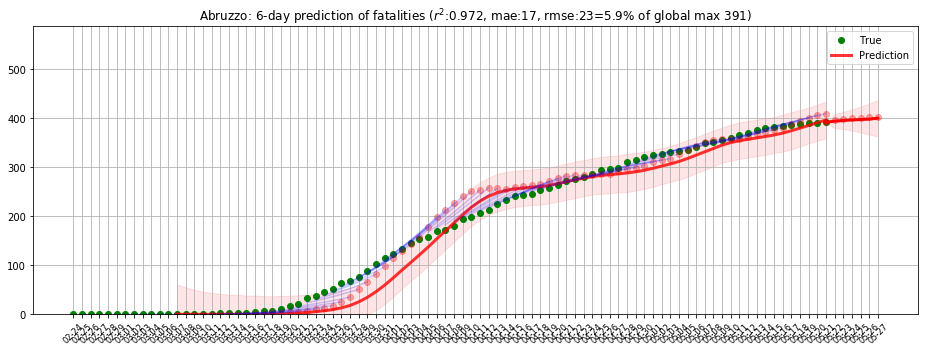

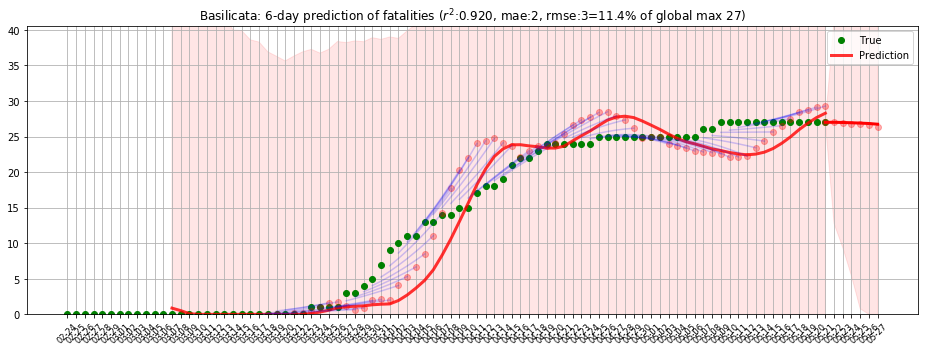

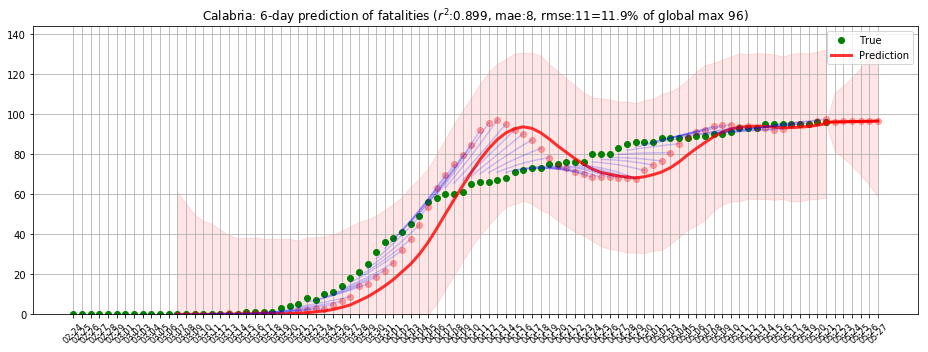

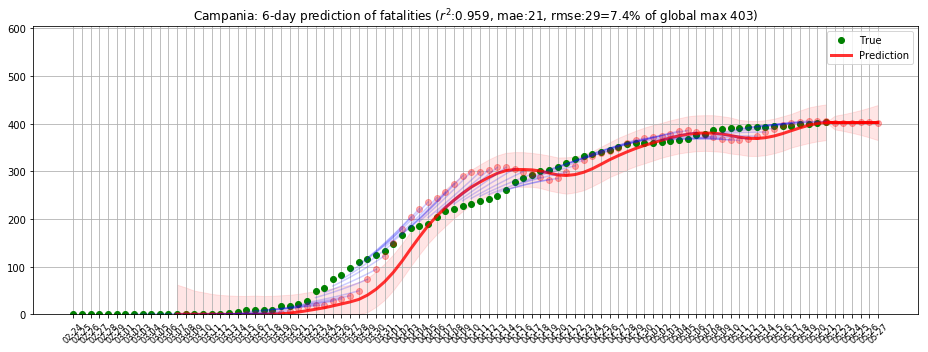

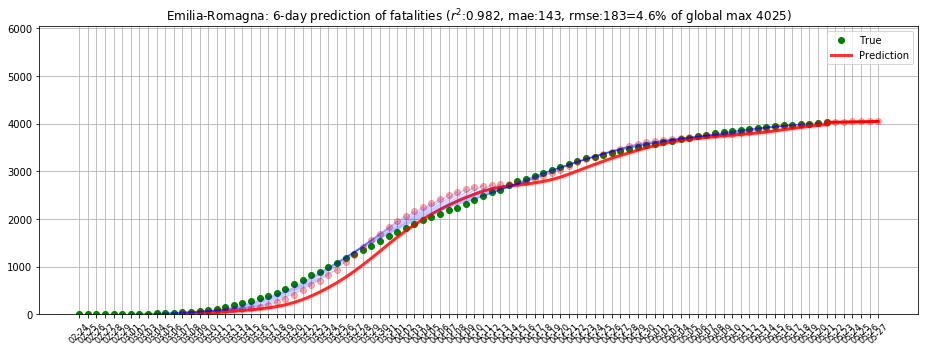

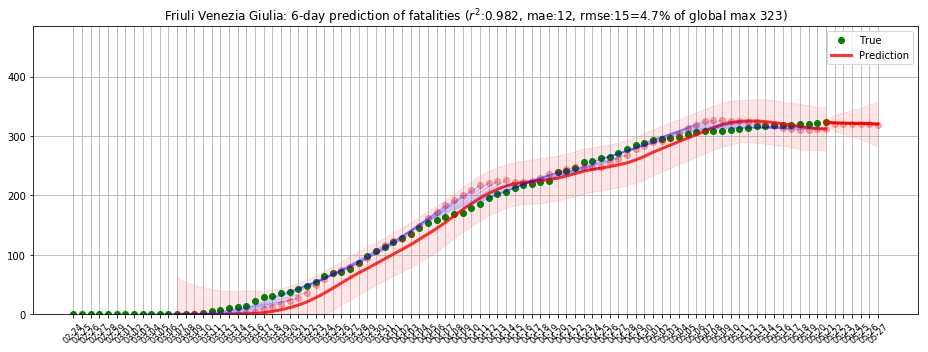

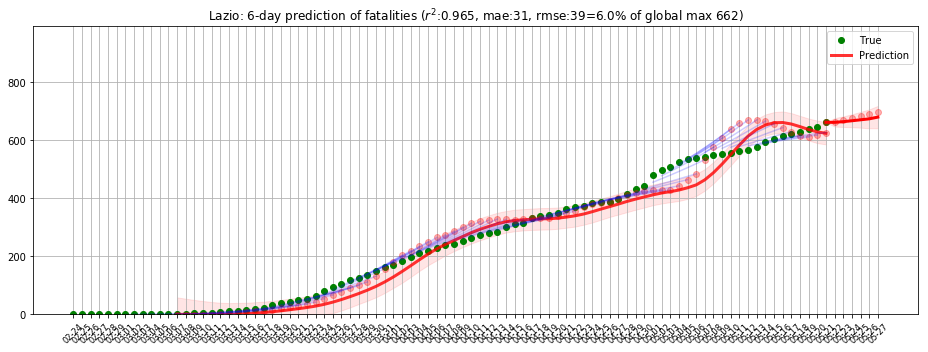

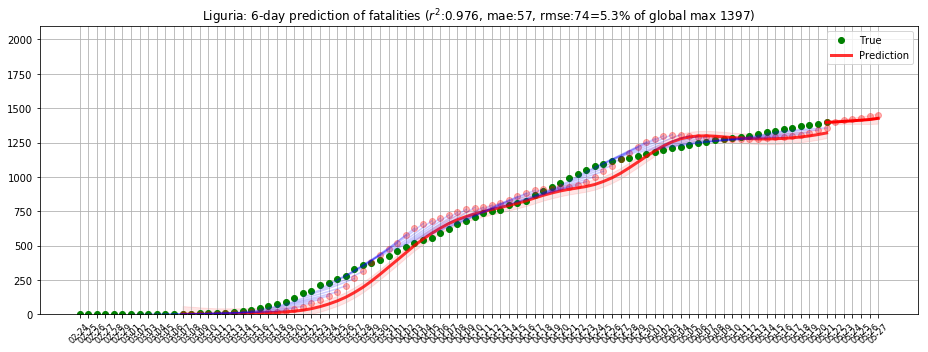

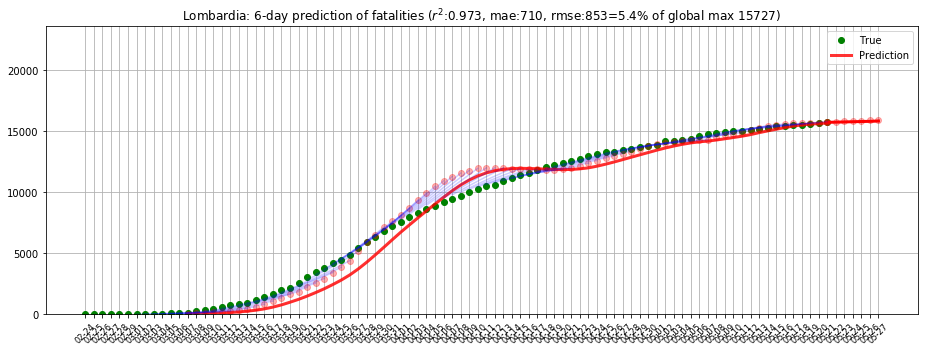

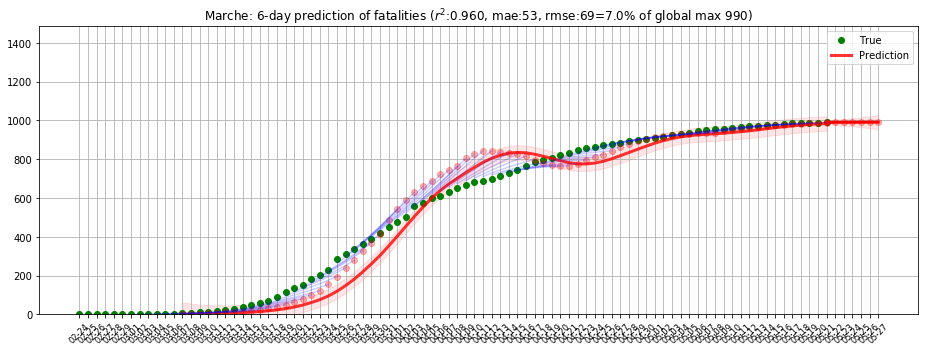

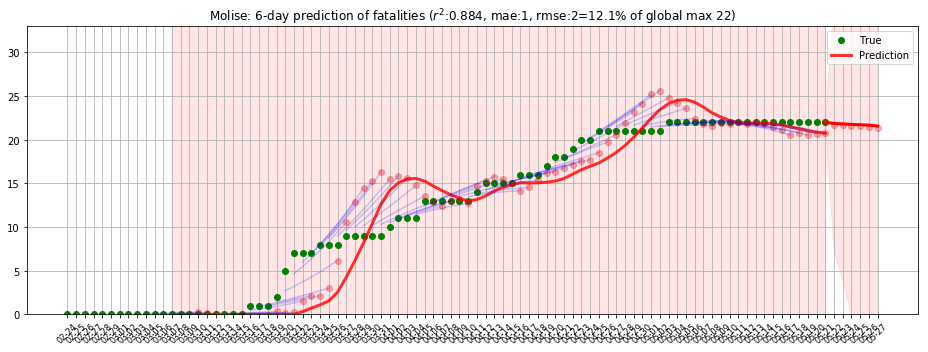

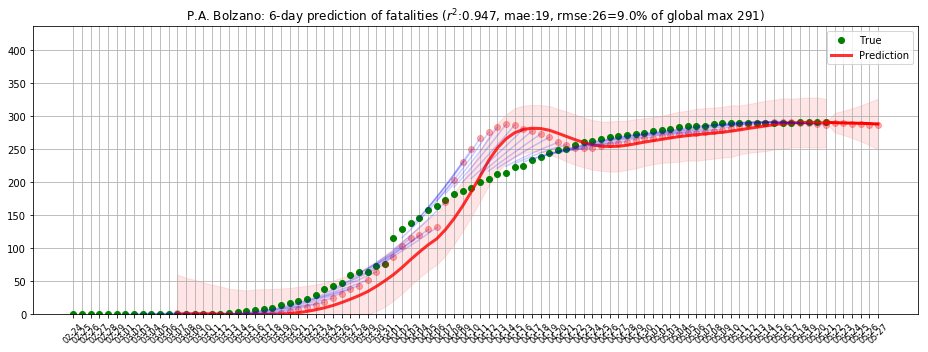

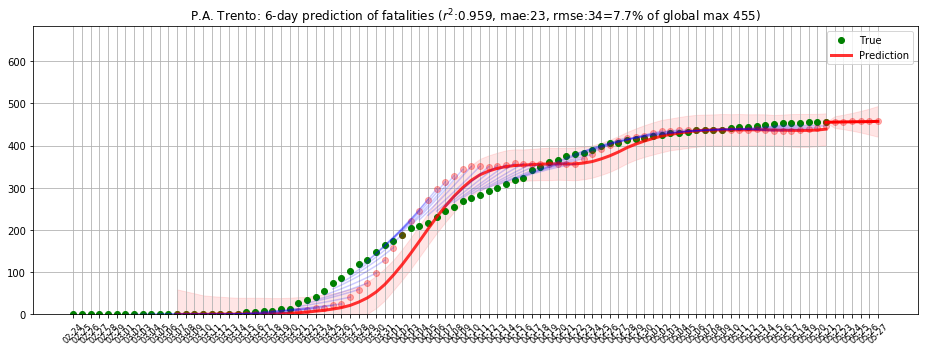

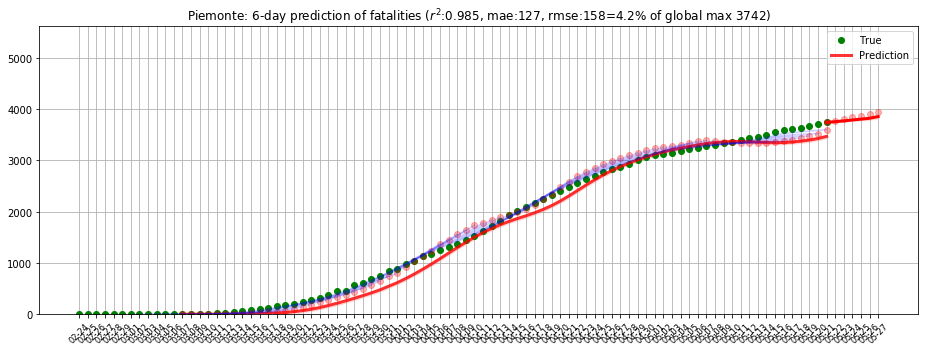

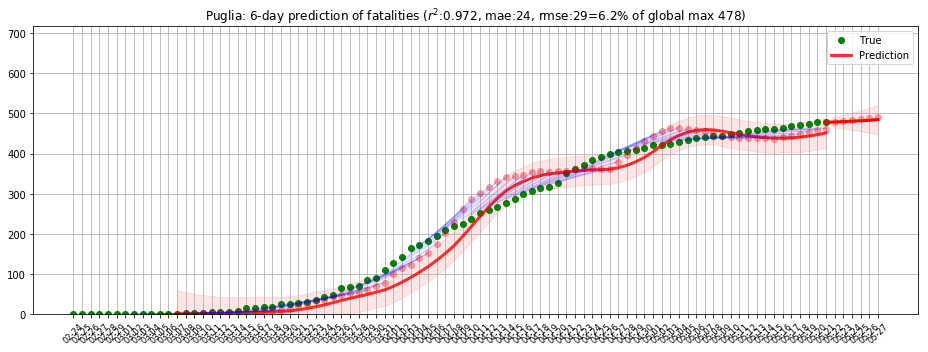

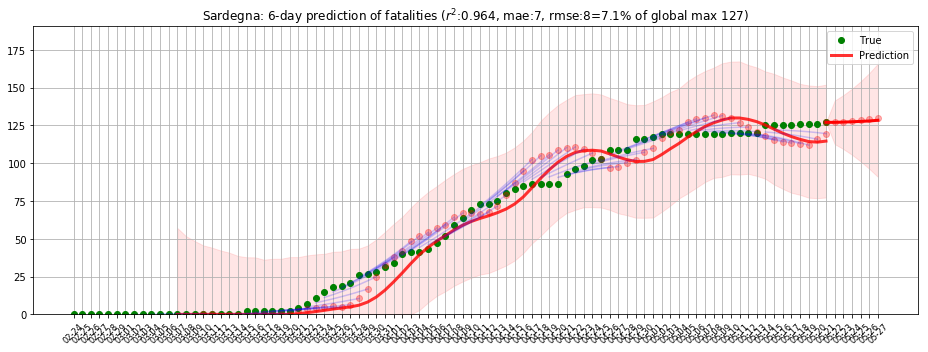

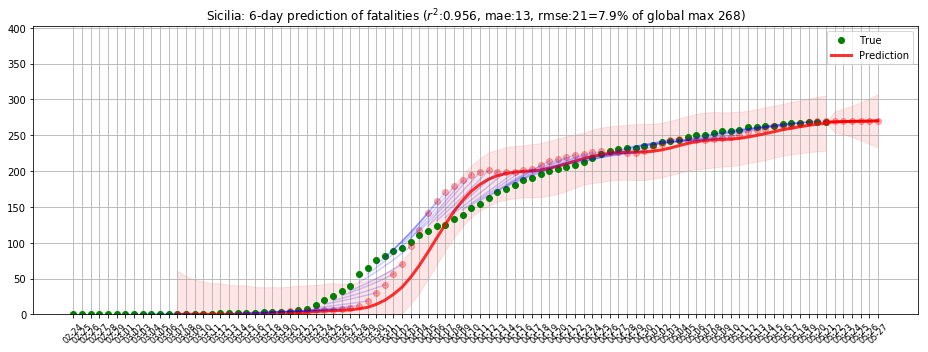

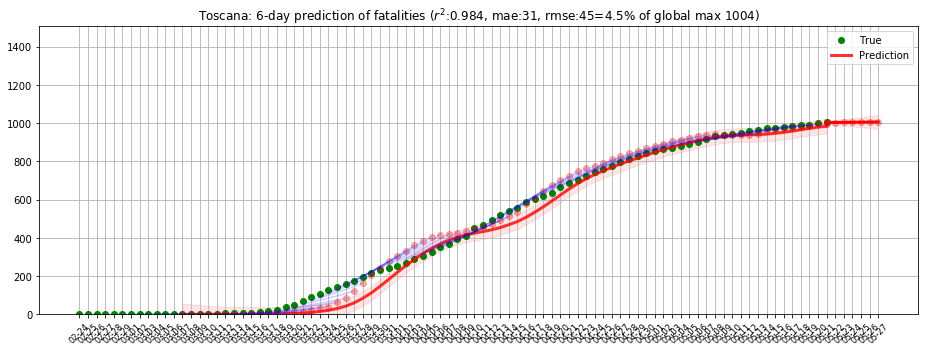

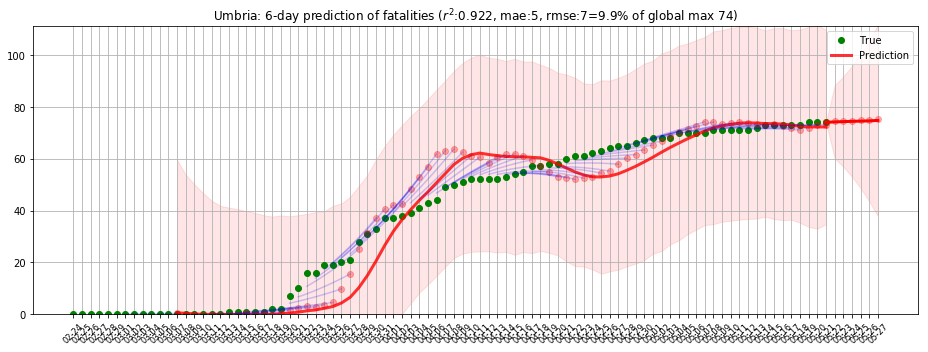

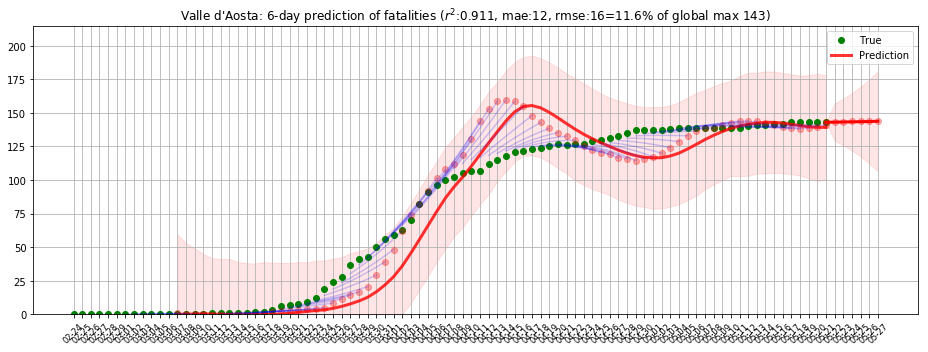

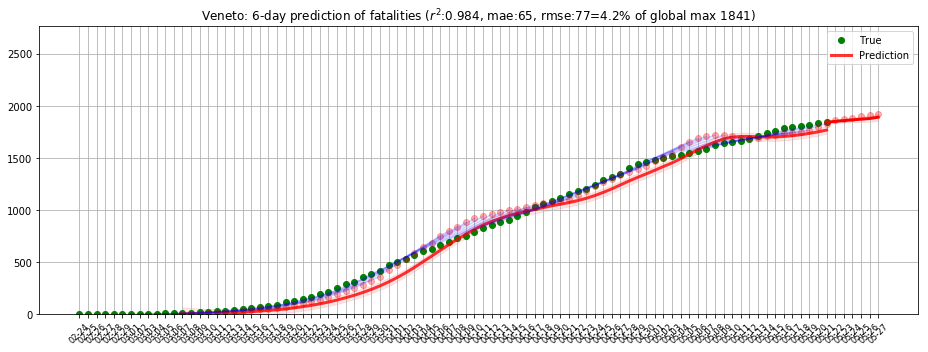

In [16]:
for region in regions:
    df_country = info_regions[info_regions.region == region].groupby('date').sum()
    if max(df_country[key]) < 10:
        continue
    df_country.index = pd.to_datetime(df_country.index, format='%Y-%m-%d').strftime('%m-%d')
    df_country = df_country[df_country.index >= '02-10'] # most measurement data starts from March
    y_lims = [min(df_country[key]) * 0.5, max(df_country[key]) * 1.5]
    test_plot(df_country[key], winsize, kf_type, kf_params, '%s: %d-day prediction of %s' % (region, winsize, key), y_lims=y_lims)
    if save_png:
        plt.savefig('%s_%s.png' % (region, key), dpi=144, transparent=False)
        plt.close()